In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.base import clone
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
seed = 1
np.random.seed(seed)

In [15]:
N = 100

# Attribute.
x = 6*np.random.rand(N, 1) - 3

# True function.
y = 2 + x + 0.5*x**2 

# Observable function.
y_noisy = y + np.random.randn(N, 1)

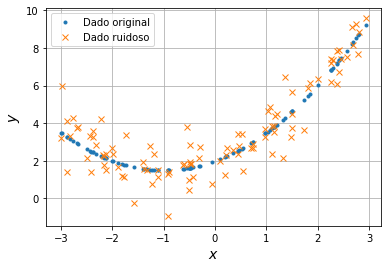

In [16]:
# Plot original data versus noisy version.
plt.plot(x, y, '.', label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

In [17]:
model_order = 90

In [18]:
X_train, X_val, y_train, y_val = train_test_split(x, 
                                                  y_noisy, 
                                                  test_size=0.3, 
                                                  random_state=seed
                                                 )

print('Training set size:', len(y_train))
print('Validation set size:', len(y_val))

poly_scaler = Pipeline([
    ("poly", PolynomialFeatures(degree=model_order, include_bias=True)),
    ("scaler", StandardScaler()),
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

Training set size: 70
Validation set size: 30


**OBS.**: Observe que com `warm_start = True`, quando o método `fit()` é chamado, ele apenas continua o treinamento de onde parou em vez de reiniciar do zero.

In [19]:
sgd_reg = SGDRegressor(max_iter=1,      # uma época.
                       tol=-np.infty,   # feito pare que o treinamento não pare pelo critério de parada.
                       penalty=None,    # nenhuma regularização.
                       eta0=0.0005,     # passo de aprendizagem constante.
                       warm_start=True,
                       learning_rate="constant",
                       random_state=seed)

n_epochs = 100000
train_errors, val_errors = [], []
minimum_val_error = float("inf")
maximum_val_error = 0.0
best_epoch = None
best_model = None
under_model = None
over_model = None
for epoch in range(n_epochs):
    # Training
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    # Prediction
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)    
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    # MSE
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    # Early-stopping
    if val_errors[epoch] < minimum_val_error:
        minimum_val_error = val_errors[epoch]
        best_epoch = epoch
        best_model = clone(sgd_reg)
        y_train_pred_best_model = y_train_predict
        
    if(epoch == 0):
        under_model = clone(sgd_reg)
        y_train_under = y_train_predict
    if(epoch == n_epochs-1):
        over_model = clone(sgd_reg)
        y_train_over = y_train_predict

Best epoch: 91


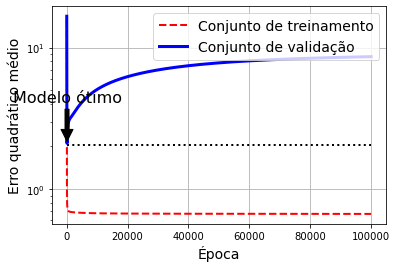

In [20]:
best_epoch = np.argmin(val_errors)
best_val_mse = val_errors[best_epoch]

print('Best epoch:', best_epoch)

plt.annotate('Modelo ótimo',
             xy=(best_epoch, best_val_mse),
             xytext=(best_epoch, best_val_mse + 2),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_mse -= 0.05  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_mse, best_val_mse], "k:", linewidth=2)
plt.plot(train_errors, "r--", linewidth=2, label="Conjunto de treinamento")
plt.plot(val_errors, "b-", linewidth=3, label="Conjunto de validação")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Época", fontsize=14)
plt.ylabel("Erro quadrático médio", fontsize=14)
plt.yscale('log')
plt.grid()
plt.savefig("early_stoppingv3_error.png", dpi=600)
#Show the plot.
plt.show()

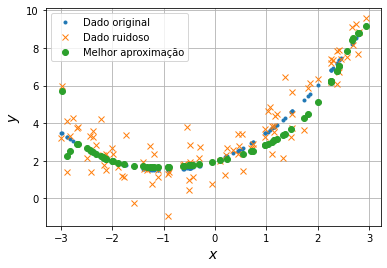

In [21]:
# Plot original data versus noisy version.
plt.plot(x, y, '.', label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(X_train, y_train_pred_best_model, 'o', label='Melhor aproximação')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.savefig("early_stoppingv3.png", dpi=600)
#Show the plot.
plt.show()

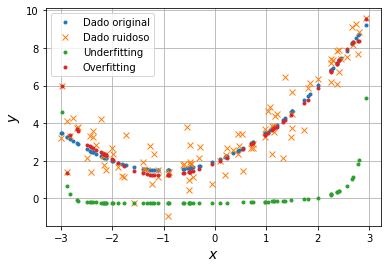

In [22]:
# Plot original data versus noisy version.
plt.plot(x, y, '.', label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(X_train, y_train_under, '.', label='Underfitting')
plt.plot(X_train, y_train_over, '.', label='Overfitting')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.savefig("early_stoppingv3.png", dpi=600)
#Show the plot.
plt.show()